In [73]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import random
from datetime import datetime
from collections import Counter
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import gluonts
from gluonts.dataset.common import ListDataset

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [91]:
data_path = 'btc_1d_engineered_selected_features.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['date'], index_col=0)
bitcoin_df = bitcoin_df.drop('target',axis=1)
bitcoin_df

,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol
date,,,,,,,,
2016-03-05,393.93,3085.475956,5.140633e+04,0.012628,0.464096,0.540899,0.566766,0.017885
2016-03-06,401.50,364.144701,5.927630e+03,0.022186,0.540183,0.834013,0.572994,0.021320
2016-03-07,412.04,2426.501107,4.128400e+04,0.026930,0.640948,0.771759,0.568524,0.023761
2016-03-08,412.09,1368.555389,2.343026e+04,0.026990,0.779819,0.688480,0.568466,0.023934
2016-03-09,411.00,3401.546586,5.813963e+04,0.023666,0.707895,0.923819,0.564374,0.022044
...,...,...,...,...,...,...,...,...
2023-03-06,22441.68,235.652360,2.204278e+05,0.017886,0.488703,1.186195,1.015165,0.019501
2023-03-07,22211.93,440.863300,4.085653e+05,0.017833,0.500007,1.215775,1.010486,0.019186
2023-03-08,21704.40,397.794102,3.653873e+05,0.010364,0.485093,0.193158,1.017991,0.015354


# Preprocess Data and split the data

In [93]:
# Normalize features
scaler = StandardScaler()
features = bitcoin_df.drop('7_day_vol', axis=1)
labels = bitcoin_df['7_day_vol']
features_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=42)


# Verify the new shape
print("New train features shape:", X_train.shape)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


New train features shape: torch.Size([2049, 7])


In [111]:
train_iter = iter(train_loader)
samples, labels = next(train_iter)

print("Sample batch shape:", samples.shape)
print("Label batch shape:", labels.shape)
print("First sample data:", samples[0])
print("First label data:", labels[0])

Sample batch shape: torch.Size([64, 7])
Label batch shape: torch.Size([64, 1])
First sample data: tensor([-0.9190, -0.5047, -0.7236,  1.9122, -0.7417, -0.2186,  0.6770])
First label data: tensor([0.0620])


# 定义 LSTNet Model

In [124]:
class LSTNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTNet, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return out

# Hyperparameter Tunning

In [136]:
criterion

MSELoss()

In [131]:
import optuna
import torch.optim as optim

def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    hidden_dim = trial.suggest_categorical('hidden_dim', [20, 50, 100])

    model = LSTNet(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training procedure
    for epoch in range(10):  # Shorter number of epochs for faster trials
        model.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    return evaluate_model(model, test_loader)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best hyperparameters: ", study.best_trial.params)


[I 2024-04-30 11:41:46,809] A new study created in memory with name: no-name-f17f9020-f7a5-4870-901c-426c44846279
[I 2024-04-30 11:41:48,490] Trial 0 finished with value: 0.00036844452582348214 and parameters: {'lr': 0.009430647190620282, 'hidden_dim': 100}. Best is trial 0 with value: 0.00036844452582348214.
[I 2024-04-30 11:41:49,462] Trial 1 finished with value: 0.0004461010151620333 and parameters: {'lr': 0.0006603695736104501, 'hidden_dim': 50}. Best is trial 0 with value: 0.00036844452582348214.
[I 2024-04-30 11:41:50,361] Trial 2 finished with value: 0.00040682429001511383 and parameters: {'lr': 0.05467974885121871, 'hidden_dim': 20}. Best is trial 0 with value: 0.00036844452582348214.
[I 2024-04-30 11:41:51,336] Trial 3 finished with value: 0.0011129235984602321 and parameters: {'lr': 1.4438236529273843e-05, 'hidden_dim': 50}. Best is trial 0 with value: 0.00036844452582348214.
[I 2024-04-30 11:41:52,994] Trial 4 finished with value: 0.0003938349222557412 and parameters: {'lr':

Best hyperparameters:  {'lr': 0.007135905293590445, 'hidden_dim': 100}


# Train the Model

In [133]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 50  # Example hyperparameter
output_dim = 1
model = LSTNet(input_dim, hidden_dim, output_dim)

# # Criterion and Optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)

# # Train the model
# train_model(model, train_loader, criterion, optimizer, num_epochs=50)



# Evaluate the Model 

In [125]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

loss = evaluate_model(model, test_loader)
print(f'Test Loss: {loss:.4f}')


Test Loss: 0.0004


In [137]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    predictions = []
    actuals = []
    total_loss = 0

    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            actuals.extend(targets.detach().cpu().numpy())

    # Calculate average loss
    average_loss = total_loss / len(test_loader)

    # Convert lists to numpy arrays for metric calculation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate additional metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    smape = 100 * np.mean(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions)))
    r2 = r2_score(actuals, predictions)

    # Print and return all metrics
    print(f"Test Loss: {average_loss:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"sMAPE: {smape:.4f}")
    print(f"R-squared: {r2:.4f}")

    return {
        'loss': average_loss,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'sMAPE': smape,
        'R2': r2
    }
# Assuming 'criterion' is defined elsewhere in your code, such as:
#criterion = torch.nn.MSELoss()

metrics = evaluate_model(model, test_loader, criterion)


ValueError: Found input variables with inconsistent numbers of samples: [513, 9]

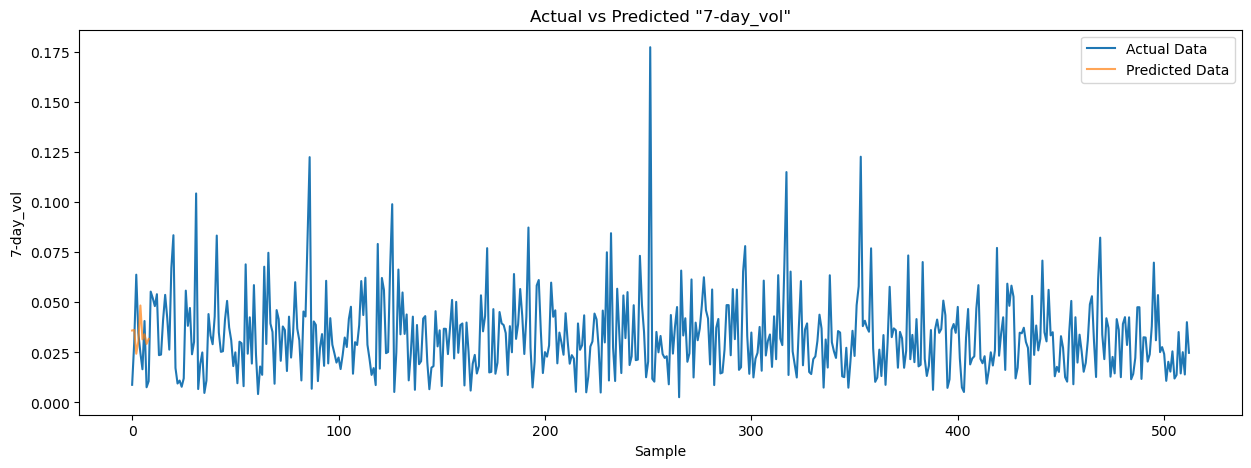

In [130]:
import matplotlib.pyplot as plt

def plot_predictions(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(targets.numpy().flatten())
    
    plt.figure(figsize=(15,5))
    plt.plot(actuals, label='Actual Data')
    plt.plot(predictions, label='Predicted Data', alpha=0.7)
    plt.title('Actual vs Predicted "7-day_vol"')
    plt.xlabel('Sample')
    plt.ylabel('7-day_vol')
    plt.legend()
    plt.show()

plot_predictions(model, test_loader)
